#### 1. SARIMA 2

    1.1. Read the dataset
    1.2. Plotting a time series
    1.3. IDENTIFICATION PROCESS, ACF and PACF of the time series 
    1.4. Stabilize the variance (if needed), Box-Cox transformation
    1.5. Difference of the time series
    1.6. Fit ARIMA model and check significance of the coefficients
    1.7. Analyze residuals
    1.8. Obtain forecasts for in-sample and out-of-sample
 
    
#### 2. SARIMA 3

    2.1. ...

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

# SARIMA 2

---
## 1. Read the dataset

In [2]:
# Import data
#df = pd.read_csv('SARIMA.csv',sep=';')
df = pd.read_csv('ARIMA_2.dat',sep=' ')
df.head()

,y
1,7.852847
2,8.263543
3,8.543455
4,8.733633
5,8.665409


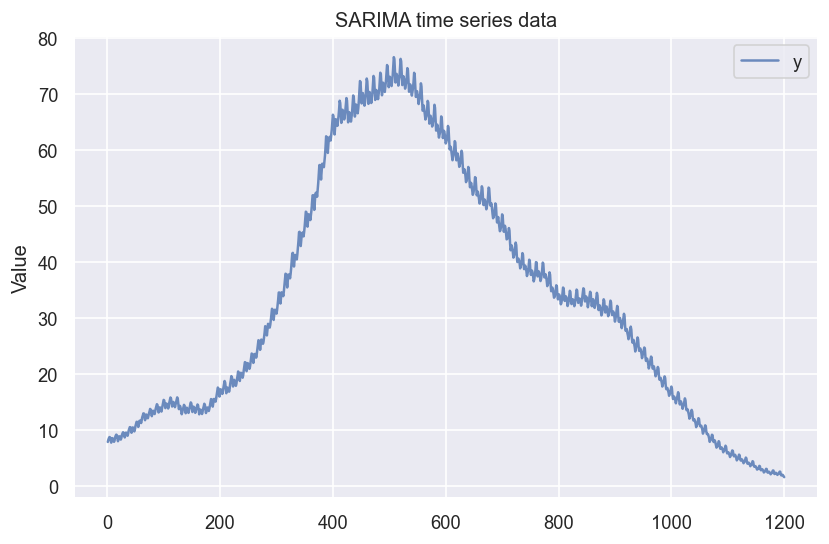

In [3]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='SARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [4]:
df_ts = df[['y']] # Maintain data.frame format for column
df_ts

,y
1,7.852847
2,8.263543
3,8.543455
4,8.733633
5,8.665409
...,...
1196,1.941215
1197,1.994511
1198,1.901136
1199,1.724911


---
### Identification process

#### 1. Plot the series and search for possible outliers

/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


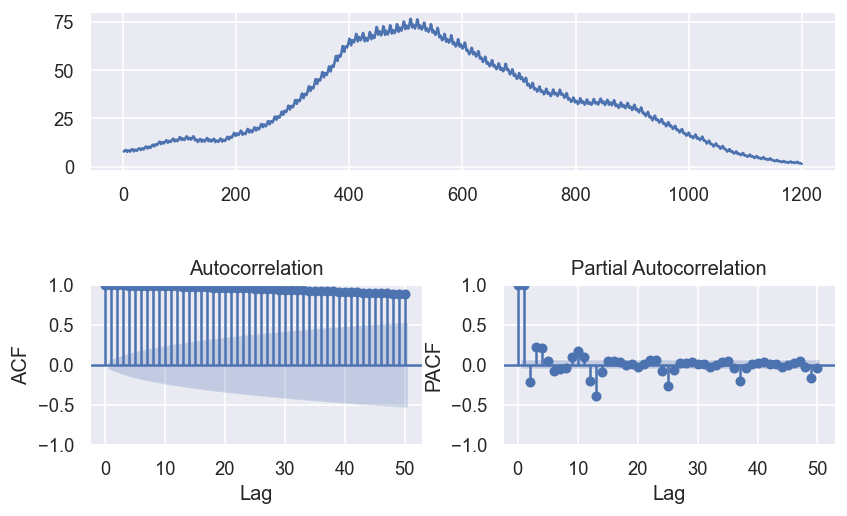

In [5]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts,lags=50)

#### 2. Stabilize the variance (if needed)

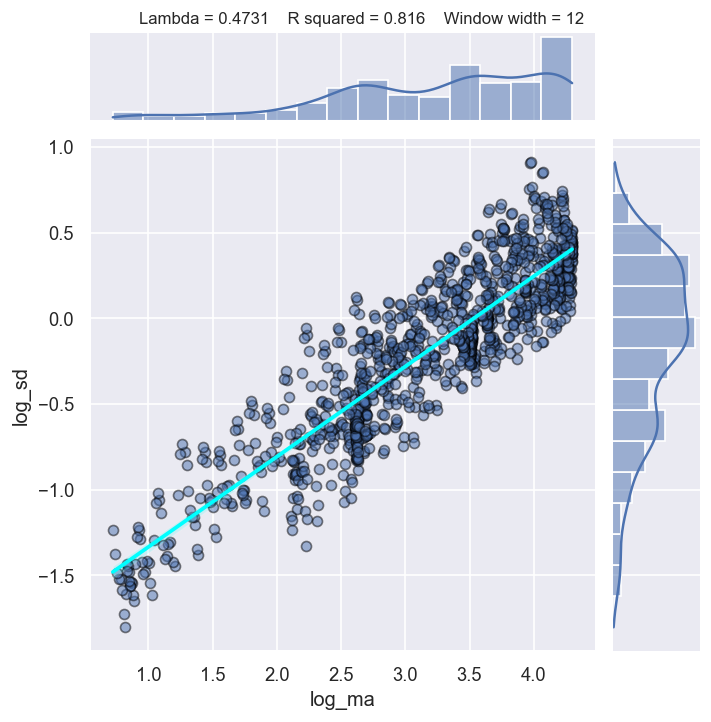

0.4731285253142954

In [6]:
# Box-Cox transformation
# Si tengo un R^2 muy distinto de 0 tenemos que aplicar la transformacion boxcos usando la lambda obtenida aqui
FT.boxcox_lambda_plot(df_ts, window_width=12) # Hemos puesto window_width = 12 porque es de periodo 12

/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


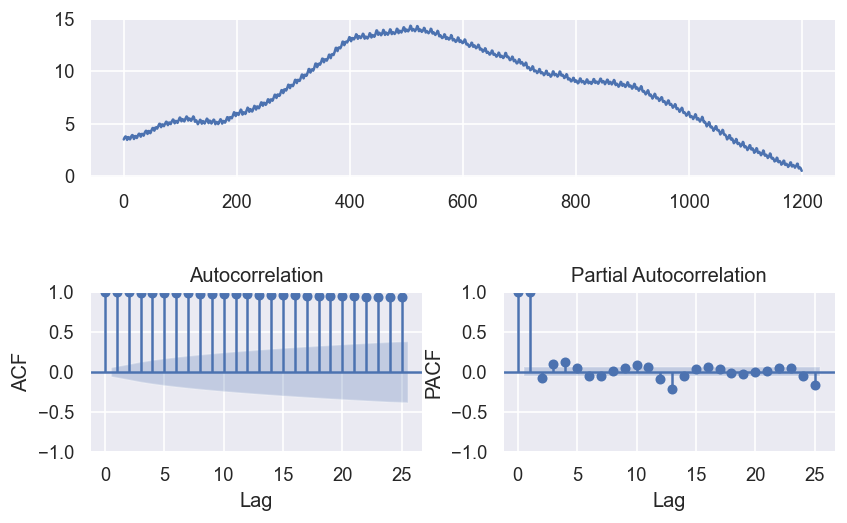

In [7]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.4731285253142954 #Select lambda
    z = st.boxcox(df_ts.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
else:
    z = df_ts

# Plot transformed data
FT.ts_display(z)

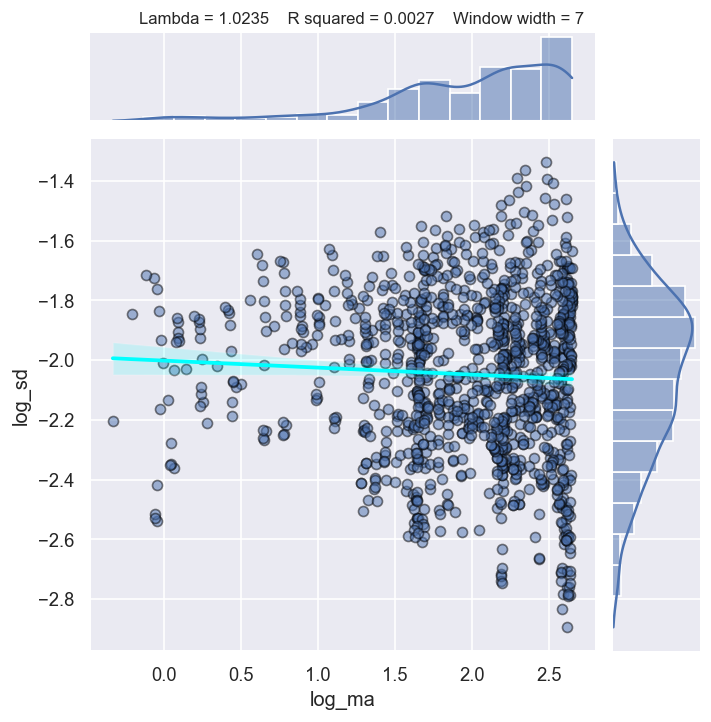

1.0234710344413864

In [8]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=7)

#### 3. Analyze stationarity 

In [9]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.939658
p-value: 0.774632
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


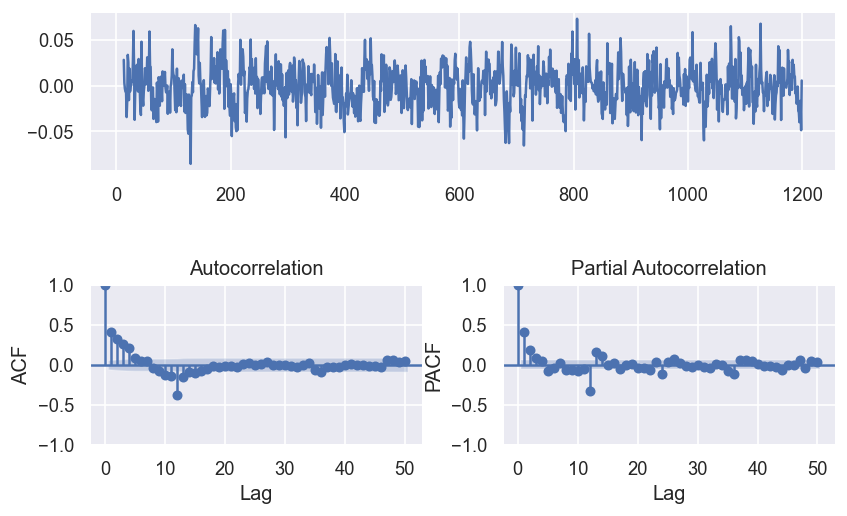

In [10]:
# Difference of the time series
# Para ver si diferenciar empezamos poniendo todo a 0
# Si ponemos (1,0,0) vemos en el ACF claramente su periodo
d = 1 # diferencia regular
D = 1 # diferencia estacional
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

+ Para la parte regular me centro en lo que ocurre antes de empezar el periodo (ACF)
+ Para la parte estacional me fijo en los periodos (PACF)

+ Regular components de abajo pongo un 1 porque diferenciamos una vez. p y q depende del grafico anterior, tanto ACF como PACF
+ Seasonal order tiene que ser el p, d, q, s

#### 5. Fit ARIMA model and check significance of the coefficients

In [11]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(2,1,0), # Regular components.
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54011D+00    |proj g|=  9.59695D+00


 This problem is unconstrained.



At iterate    5    f= -2.55078D+00    |proj g|=  6.12524D-02

At iterate   10    f= -2.55117D+00    |proj g|=  1.94965D+00

At iterate   15    f= -2.55283D+00    |proj g|=  7.44533D-03

At iterate   20    f= -2.55286D+00    |proj g|=  1.89871D-01

At iterate   25    f= -2.55286D+00    |proj g|=  2.25838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      1     0     0   5.883D-04  -2.553D+00
  F =  -2.5528641224334168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                       
Dep. Variable:      


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


#### 6. Analyze residuals

/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  33.925765   0.109504


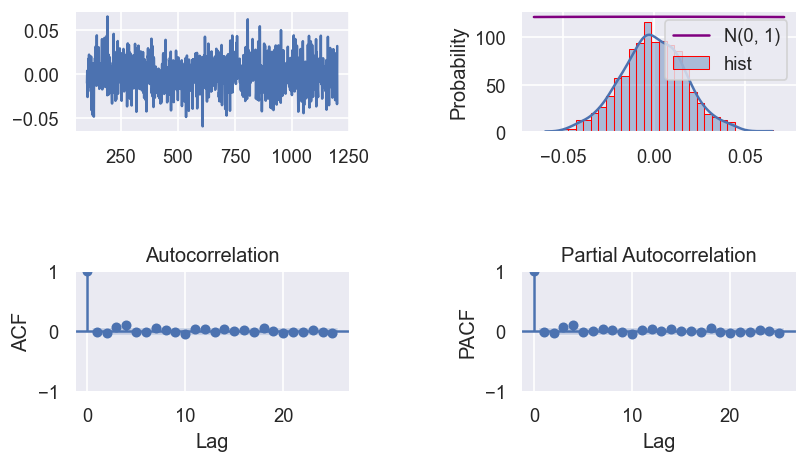

In [12]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

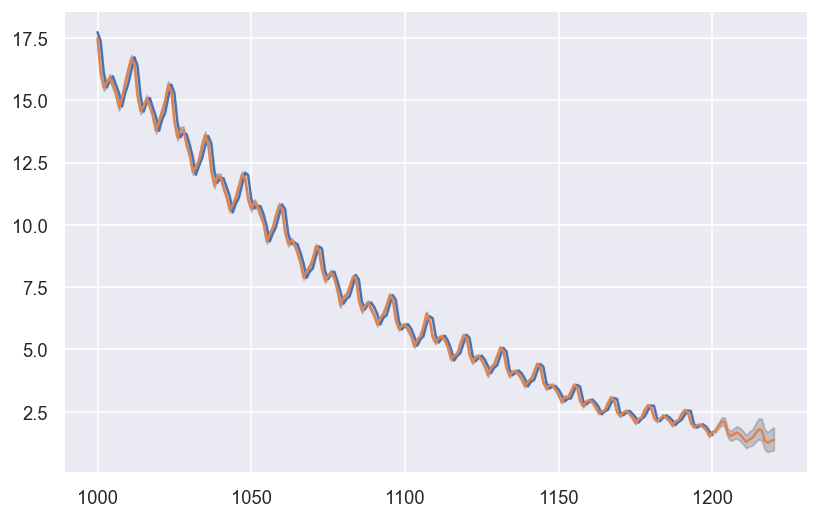

In [13]:
#Obtain forecasts for in-sample and out-of-sample
start = 1000
horizon = 20 # prediccion a 20 instantes
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()

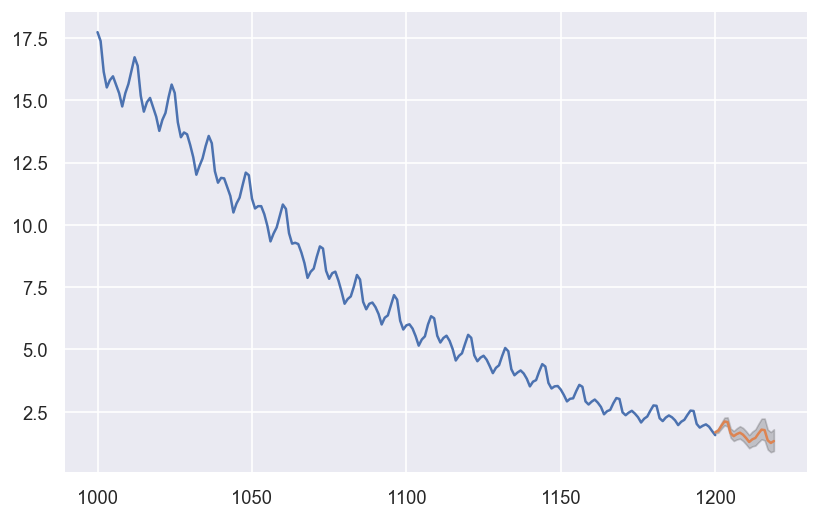

In [14]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 20
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[1000:])
plt.plot(yhat)
plt.show()

# SARIMA 3

In [15]:
# Import data
#df = pd.read_csv('SARIMA.csv',sep=';')
df = pd.read_csv('ARIMA_3.dat',sep=' ')
df.head()

,y
1,16.009336
2,15.856565
3,16.194833
4,15.951635
5,16.326722


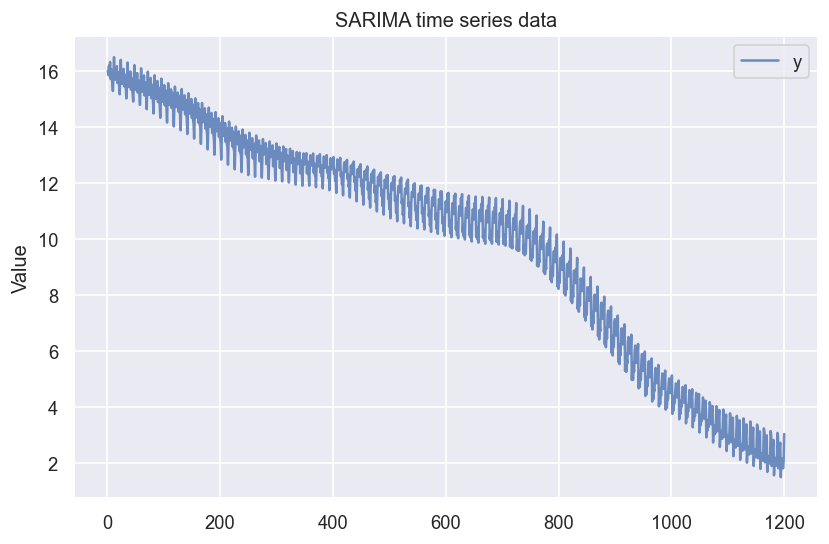

In [16]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='SARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [17]:
df_ts = df[['y']] # Maintain data.frame format for column
df_ts

,y
1,16.009336
2,15.856565
3,16.194833
4,15.951635
5,16.326722
...,...
1196,2.161339
1197,2.062422
1198,1.815336
1199,2.077532


/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


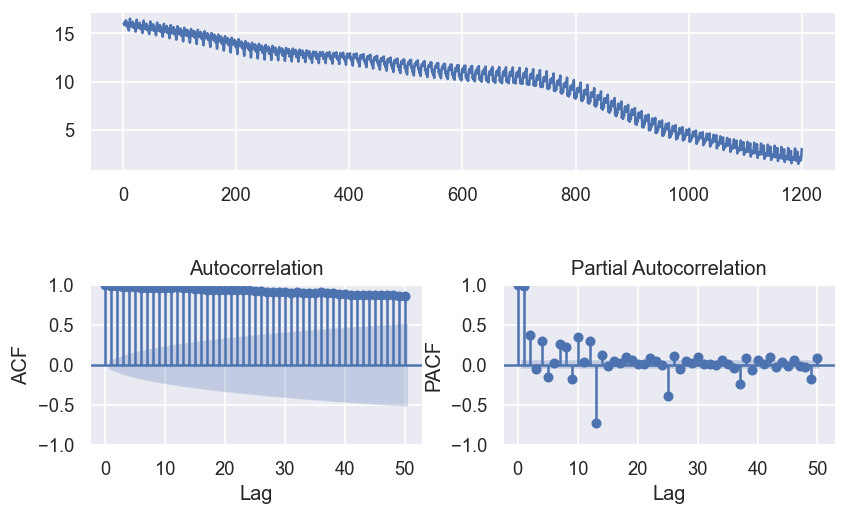

In [18]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts,lags=50)

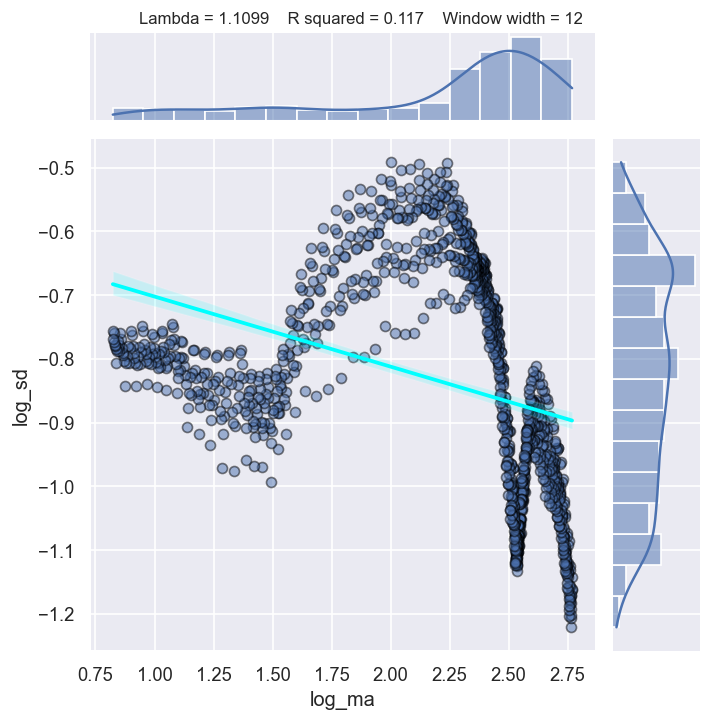

1.1099157248193796

In [19]:
# Box-Cox transformation
# Si tengo un R^2 muy distinto de 0 tenemos que aplicar la transformacion boxcos usando la lambda obtenida aqui
FT.boxcox_lambda_plot(df_ts, window_width=12) # Hemos puesto window_width = 12 porque es de periodo 12

/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


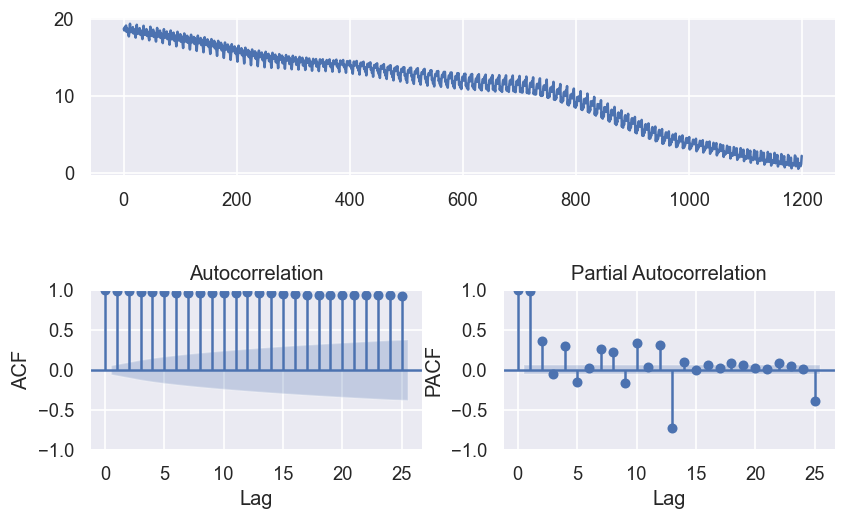

In [20]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 1.1099 #Select lambda
    z = st.boxcox(df_ts.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
else:
    z = df_ts

# Plot transformed data
FT.ts_display(z)

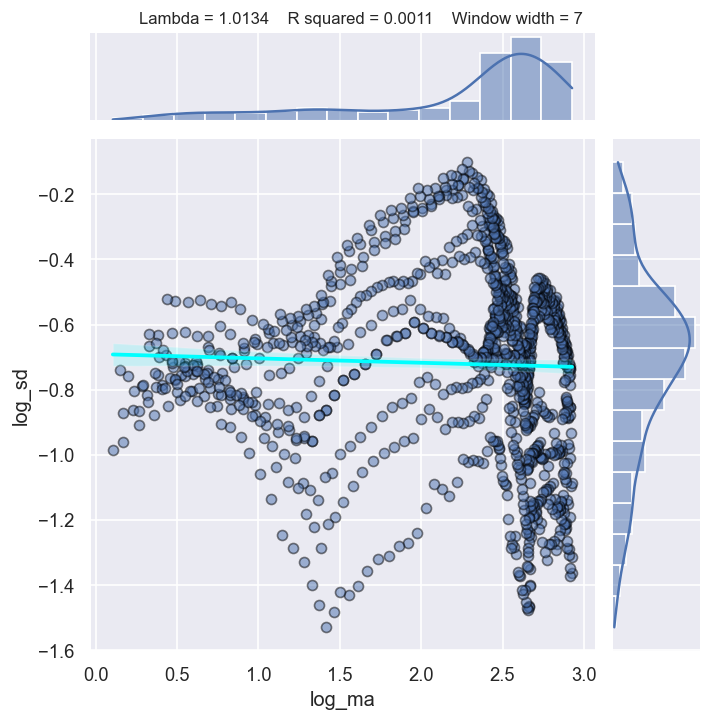

1.013430848548666

In [21]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=7)

In [22]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.165669
p-value: 0.218941
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


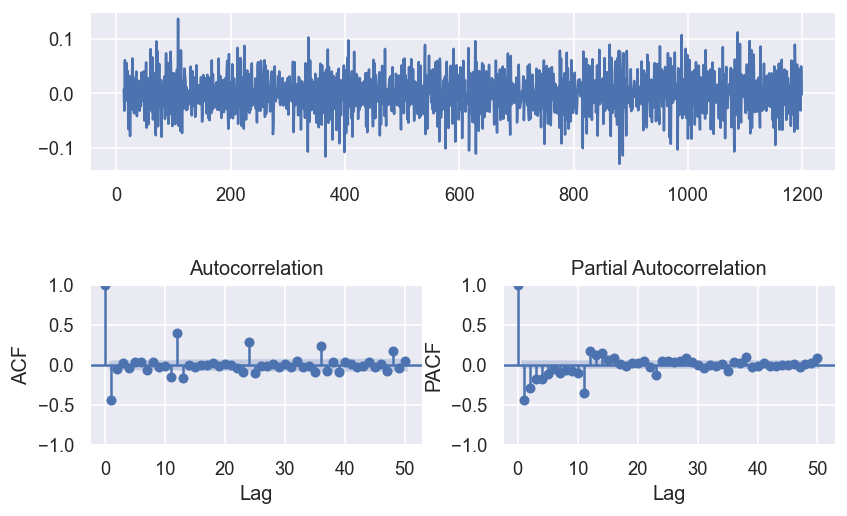

In [23]:
# Difference of the time series
# Para ver si diferenciar empezamos poniendo todo a 0
# Si ponemos (1,0,0) vemos en el ACF claramente su periodo
d = 1 # diferencia regular
D = 1 # diferencia estacional
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

In [24]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,1,1), # Regular components.
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.01329D+00    |proj g|=  5.04050D+00

At iterate    5    f= -2.02426D+00    |proj g|=  2.55866D+00

At iterate   10    f= -2.03856D+00    |proj g|=  1.82493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   4.377D-05  -2.039D+00
  F =  -2.0385582410105787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

/usr/local/Caskroom/miniforge/base/envs/fmad/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
       lb_stat     lb_pvalue
25  115.917496  1.154350e-13


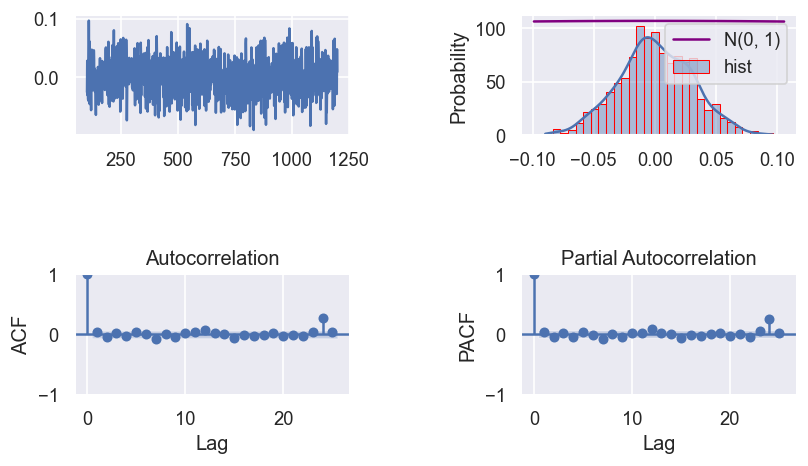

In [25]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

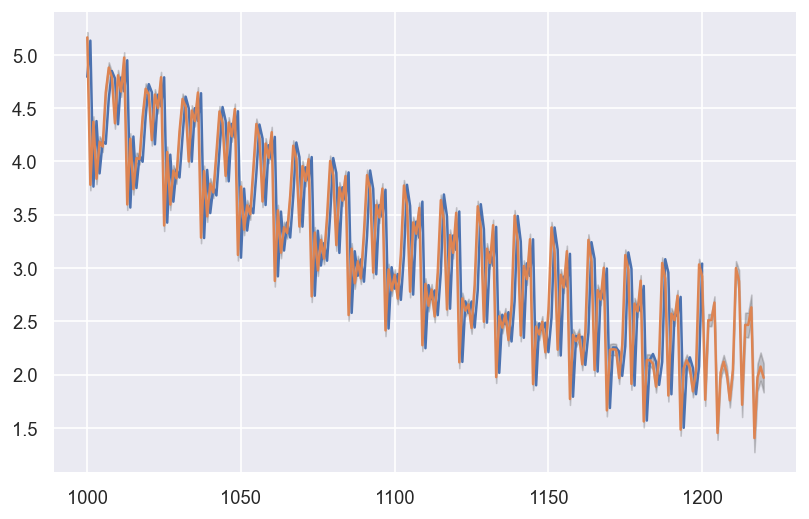

In [26]:
#Obtain forecasts for in-sample and out-of-sample
start = 1000
horizon = 20 # prediccion a 20 instantes
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()